In [105]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.utils import resample
import numpy as np
from PIL import Image
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import gzip
import shutil
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
import joblib
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from tensorflow.keras.models import load_model
import joblib

In [106]:
base_path = "/home/sanket-janger/Documents/project/physionet.org/files/mimic-cxr-jpg/2.1.0"
chexpert_path = os.path.join(base_path, "mimic-cxr-2.0.0-chexpert.csv")
chexpert_df = pd.read_csv(chexpert_path)

chexpert_df.head()

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,10000032,50414267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,10000032,53189527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,10000032,53911762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,10000032,56699142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,10000764,57375967,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN


In [107]:
BASE_DIR = "/home/sanket-janger/Documents/project/physionet.org/files/mimic-cxr-jpg/2.1.0"
IMG_DIR = os.path.join(BASE_DIR, "files")
CHEXPERT_CSV = os.path.join(BASE_DIR, "mimic-cxr-2.0.0-chexpert.csv")
META_CSV = os.path.join(BASE_DIR, "mimic-cxr-2.0.0-metadata.csv")

In [108]:
chexpert_df = pd.read_csv(CHEXPERT_CSV)
meta_df = pd.read_csv(META_CSV)

print("CheXpert shape:", chexpert_df.shape)
print("Metadata shape:", meta_df.shape)

CheXpert shape: (227827, 16)
Metadata shape: (377110, 12)


In [109]:
# Just to be safe, removing any trailing spaces in column names
chexpert_df.columns = chexpert_df.columns.str.strip()
meta_df.columns = meta_df.columns.str.strip()

# Merge on subject_id and study_id
df = pd.merge(chexpert_df, meta_df, on=["subject_id", "study_id"])
print(" Merged shape:", df.shape)

 Merged shape: (377095, 26)


In [110]:
# Drop rows where pneumonia is missing (NaN) or uncertain (-1)
df_filtered = df[df["Pneumonia"].isin([0, 1])].copy()

print("Cleaned rows with pneumonia labels (0 or 1):", df_filtered.shape[0])

Cleaned rows with pneumonia labels (0 or 1): 69580


In [111]:
# Split into pneumonia vs non-pneumonia
df_pos = df_filtered[df_filtered["Pneumonia"] == 1]
df_neg = df_filtered[df_filtered["Pneumonia"] == 0]

# Sample 500 from each
df_pos_sampled = resample(df_pos, n_samples=500, random_state=42)
df_neg_sampled = resample(df_neg, n_samples=500, random_state=42)

# Combine and shuffle
df_sampled = pd.concat([df_pos_sampled, df_neg_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)
print("Final sample size:", df_sampled.shape)

Final sample size: (1000, 26)


In [112]:
IMG_DIR = "/home/sanket/Documents/project/physionet.org/files/mimic-cxr-jpg/2.1.0/files"

def build_path(row):
    subdir = f"p{str(row['subject_id'])}"
    return os.path.join(IMG_DIR, subdir[:3], subdir, str(row['study_id']), f"{row['dicom_id']}.jpg")

df_sampled['img_path'] = df_sampled.apply(build_path, axis=1)

# Preview the first few
df_sampled[['dicom_id', 'Pneumonia', 'img_path']].head()

,dicom_id,Pneumonia,img_path
0,562f426a-ddbaaaac-9e7209df-af912614-0343307a,0.0,/home/sanket/Documents/project/physionet.org/f...
1,f75213de-235af99f-6207dad1-0b29ff84-b7ce905b,0.0,/home/sanket/Documents/project/physionet.org/f...
2,a72b323a-cf9c5c27-a61cb36d-3b952e03-c86b24fc,0.0,/home/sanket/Documents/project/physionet.org/f...
3,266494fd-7a7cd168-125d2c00-42460dc5-ff323b2a,0.0,/home/sanket/Documents/project/physionet.org/f...
4,a2d43da0-dd80cfcc-37e55c59-91572344-315059bb,1.0,/home/sanket/Documents/project/physionet.org/f...


In [113]:
# Checking which files exist
df_sampled['file_exists'] = df_sampled['img_path'].apply(os.path.exists)

# Printing how many images are missing
missing_count = (~df_sampled['file_exists']).sum()
print(f"Missing image files: {missing_count}")

Missing image files: 1000


In [114]:
root = "/home/sanket-janger/Documents/project/physionet.org/files/mimic-cxr-jpg/2.1.0/files"

count = 0
for dirpath, _, filenames in os.walk(root):
    for f in filenames:
        if f.endswith(".jpg"):
            print("Found image:", os.path.join(dirpath, f))
            count += 1
            if count == 5:
                break
    if count > 0:
        break


Found image: /home/sanket-janger/Documents/project/physionet.org/files/mimic-cxr-jpg/2.1.0/files/p10/p10200795/s51837399/221d9898-7de559d6-cc22b591-7cc79e67-b7268980.jpg
Found image: /home/sanket-janger/Documents/project/physionet.org/files/mimic-cxr-jpg/2.1.0/files/p10/p10200795/s51837399/6bfd6ec3-07dab3c4-1d314012-ecdca11b-27446e8d.jpg


In [115]:
IMG_DIR = "/home/sanket-janger/Documents/project/physionet.org/files/mimic-cxr-jpg/2.1.0/files"

def build_path(row):
    subject = f"p{row['subject_id']}"
    study = f"s{row['study_id']}"
    return os.path.join(IMG_DIR, subject[:3], subject, study, f"{row['dicom_id']}.jpg")

df_sampled['img_path'] = df_sampled.apply(build_path, axis=1)


In [116]:
df_sampled['file_exists'] = df_sampled['img_path'].apply(os.path.exists)
missing_count = (~df_sampled['file_exists']).sum()
print(f"Missing image files: {missing_count}")

Missing image files: 967


In [117]:
IMG_DIR = "/home/sanket-janger/Documents/project/physionet.org/files/mimic-cxr-jpg/2.1.0/files"
p10_dir = os.path.join(IMG_DIR, "p10")

valid_images = []

image_count = 0
for subj_folder in sorted(os.listdir(p10_dir)):
    subj_path = os.path.join(p10_dir, subj_folder)
    if not os.path.isdir(subj_path): continue

    try:
        subject_id = int(subj_folder[1:])  # strip "p"
    except:
        continue

    for study_folder in os.listdir(subj_path):
        study_path = os.path.join(subj_path, study_folder)
        if not os.path.isdir(study_path): continue

        try:
            study_id = int(study_folder[1:])  # strip "s"
        except:
            continue

        for img_file in os.listdir(study_path):
            if img_file.endswith(".jpg"):
                dicom_id = img_file.replace(".jpg", "")
                valid_images.append((subject_id, study_id, dicom_id))

                image_count += 1
                if image_count >= 10000:
                    break
        if image_count >= 10000:
            break
    if image_count >= 10000:
        break

# Convert to DataFrame
valid_df = pd.DataFrame(valid_images, columns=["subject_id", "study_id", "dicom_id"])
print("Collected valid image info:", len(valid_df))

Collected valid image info: 10000


In [118]:
# Step 1: Strip columns just in case (always good practice)
chexpert_df.columns = chexpert_df.columns.str.strip()
valid_df.columns = valid_df.columns.str.strip()

# Merge using only subject_id and study_id
merged_df = pd.merge(valid_df, chexpert_df, on=["subject_id", "study_id"])
print("Merged shape:", merged_df.shape)

Merged shape: (10000, 17)


In [119]:
df_filtered = merged_df[merged_df["Pneumonia"].isin([0, 1])].copy()
print("Pneumonia-labeled rows:", df_filtered.shape[0])

# Balance positive and negative cases
df_pos = df_filtered[df_filtered["Pneumonia"] == 1]
df_neg = df_filtered[df_filtered["Pneumonia"] == 0]

df_pos_sampled = resample(df_pos, n_samples=500, random_state=42)
df_neg_sampled = resample(df_neg, n_samples=500, random_state=42)

df_sampled = pd.concat([df_pos_sampled, df_neg_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)
print("Final balanced sample:", df_sampled.shape)

Pneumonia-labeled rows: 1809
Final balanced sample: (1000, 17)


In [120]:
IMG_DIR = "/home/sanket-janger/Documents/project/physionet.org/files/mimic-cxr-jpg/2.1.0/files"

def build_path(row):
    subject = f"p{row['subject_id']}"
    study = f"s{row['study_id']}"
    return os.path.join(IMG_DIR, subject[:3], subject, study, f"{row['dicom_id']}.jpg")

df_sampled['img_path'] = df_sampled.apply(build_path, axis=1)

In [121]:
df_sampled['file_exists'] = df_sampled['img_path'].apply(os.path.exists)
missing = df_sampled['file_exists'].value_counts()
print("File check:\n", missing)

File check:
 file_exists
True    1000
Name: count, dtype: int64


In [122]:
def load_and_preprocess_images(df, img_size=(224, 224)):
    X = []
    for path in tqdm(df['img_path'], desc="Loading images"):
        img = Image.open(path).convert("RGB")  # ensures 3 channels
        img = img.resize(img_size)
        X.append(np.array(img) / 255.0)  # normalize pixel values
    return np.array(X)

In [123]:
X = load_and_preprocess_images(df_sampled)
y = df_sampled["Pneumonia"].values

Loading images: 100%|███████████████████████| 1000/1000 [00:48<00:00, 20.59it/s]


Found 800 validated image filenames.
Found 200 validated image filenames.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,430,273 (9.27 MB)

 Trainable params: 172,289 (673.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

/home/sanket-janger/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5081 - loss: 0.7291 - val_accuracy: 0.5350 - val_loss: 0.6893
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6600 - loss: 0.6419 - val_accuracy: 0.5900 - val_loss: 0.6695
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6930 - loss: 0.6046 - val_accuracy: 0.6300 - val_loss: 0.6547
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7141 - loss: 0.5831 - val_accuracy: 0.6250 - val_loss: 0.6562
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7708 - loss: 0.5454 - val_accuracy: 0.6450 - val_loss: 0.6345
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7843 - loss: 0.5184 - val_accuracy: 0.6400 - val_loss: 0.6238
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8017 - loss: 0.4985 - val_accuracy: 0.6350 - val_loss: 0.6193
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8160 - loss: 0.4735 - val_accuracy: 0.6600 - v

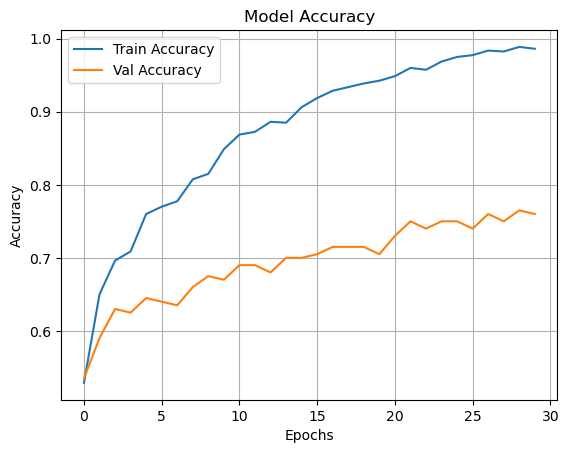

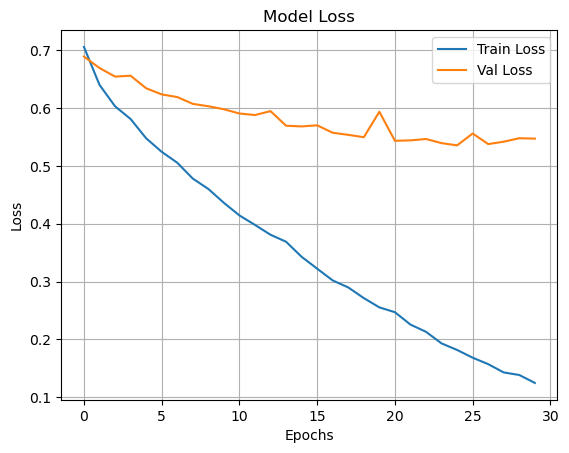

In [124]:
# Split dataset
train_df, val_df = train_test_split(
    df_sampled,
    test_size=0.2,
    stratify=df_sampled["Pneumonia"],
    random_state=42
)

# Set up image generators
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(
    train_df,
    x_col='img_path',
    y_col='Pneumonia',
    target_size=(224, 224),
    batch_size=32,         # You can also try 16 or 64 depending on GPU
    class_mode='raw',
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    val_df,
    x_col='img_path',
    y_col='Pneumonia',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    shuffle=False
)

# Define model
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze base

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)  # Slightly increased layer size
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

# Add EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

## Train model (100 epochs)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks=[early_stop],
    verbose=1
)

# Plot accuracy and loss
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [125]:
model.save("mobilenet_pneumonia_100epoch_earlystop.keras")
print("Model saved as 'mobilenet_pneumonia_100epoch_earlystop.keras'")

Model saved as 'mobilenet_pneumonia_100epoch_earlystop.keras'


In [126]:
import gzip
import shutil
import os

gz_files = [
    "patients.csv.gz",
    "admissions.csv.gz"
]

source_dir = "/home/sanket-janger/Documents/project/physionet.org/files/mimiciv/2.2/hosp"

for file in gz_files:
    gz_path = os.path.join(source_dir, file)
    csv_path = gz_path.replace('.gz', '')
    if os.path.exists(gz_path) and not os.path.exists(csv_path):
        with gzip.open(gz_path, 'rb') as f_in:
            with open(csv_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        print(f"Decompressed: {file}")
    else:
        print(f"Already decompressed or missing: {file}")


Already decompressed or missing: patients.csv.gz
Already decompressed or missing: admissions.csv.gz


In [127]:
patients_df = pd.read_csv("/home/sanket-janger/Documents/project/physionet.org/files/mimiciv/2.2/hosp/patients.csv")
admissions_df = pd.read_csv("/home/sanket-janger/Documents/project/physionet.org/files/mimiciv/2.2/hosp/admissions.csv")

patients_df.head(), admissions_df.head()

(   subject_id gender  anchor_age  anchor_year anchor_year_group         dod
 0    10000032      F          52         2180       2014 - 2016  2180-09-09
 1    10000048      F          23         2126       2008 - 2010         NaN
 2    10000068      F          19         2160       2008 - 2010         NaN
 3    10000084      M          72         2160       2017 - 2019  2161-02-13
 4    10000102      F          27         2136       2008 - 2010         NaN,
    subject_id   hadm_id            admittime            dischtime deathtime  \
 0    10000032  22595853  2180-05-06 22:23:00  2180-05-07 17:15:00       NaN   
 1    10000032  22841357  2180-06-26 18:27:00  2180-06-27 18:49:00       NaN   
 2    10000032  25742920  2180-08-05 23:44:00  2180-08-07 17:50:00       NaN   
 3    10000032  29079034  2180-07-23 12:35:00  2180-07-25 17:55:00       NaN   
 4    10000068  25022803  2160-03-03 23:16:00  2160-03-04 06:26:00       NaN   
 
    admission_type admit_provider_id      admission_loc

In [128]:
# Load data again
patients_df = pd.read_csv("/home/sanket-janger/Documents/project/physionet.org/files/mimiciv/2.2/hosp/patients.csv")
admissions_df = pd.read_csv("/home/sanket-janger/Documents/project/physionet.org/files/mimiciv/2.2/hosp/admissions.csv")

In [129]:
patients_df_cleaned = patients_df[[
    "subject_id",
    "gender",
    "anchor_age", 
    
]]
admissions_df_cleaned = admissions_df[[
    "subject_id", "hospital_expire_flag"
]]

In [130]:
tabular_df = pd.merge(
    patients_df_cleaned,
    admissions_df_cleaned,
    on="subject_id", 
    how="left"
)

In [131]:
tabular_df[["subject_id", "anchor_age", "gender"]].head(100)

,subject_id,anchor_age,gender
0,10000032,52,F
1,10000032,52,F
2,10000032,52,F
3,10000032,52,F
4,10000048,23,F
...,...,...,...
95,10001884,68,F
96,10001884,68,F
97,10001884,68,F
98,10001884,68,F


In [132]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import joblib

# Load the CSVs again
patients_df = pd.read_csv("/home/sanket-janger/Documents/project/physionet.org/files/mimiciv/2.2/hosp/patients.csv")
admissions_df = pd.read_csv("/home/sanket-janger/Documents/project/physionet.org/files/mimiciv/2.2/hosp/admissions.csv")

# Clean + merge
patients_df_cleaned = patients_df[["subject_id", "gender", "anchor_age"]]
admissions_df_cleaned = admissions_df[[
    "subject_id",
    "hospital_expire_flag"
]]

# Select features and drop missing
features = ["anchor_age", "gender"]
df_xgb = tabular_df[features + ["hospital_expire_flag"]].dropna()

# Encode categoricals
le_gender = LabelEncoder()
df_xgb["gender"] = le_gender.fit_transform(df_xgb["gender"])

# Prepare data
X = df_xgb[features]
y = df_xgb["hospital_expire_flag"]

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Evaluate
y_pred = xgb_model.predict(X_val)
y_prob = xgb_model.predict_proba(X_val)[:, 1]

accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

# Save model
joblib.dump(xgb_model, "xgb_clinical_model.pkl")
print("Model saved as xgb_clinical_model.pkl")


/home/sanket-janger/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:09:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9800
AUC-ROC: 0.7071
Model saved as xgb_clinical_model.pkl


In [133]:
# Check class balance
y.value_counts(normalize=True)

# Remove 'length_of_stay' or 'discharge_location' and retrain
# Use a confusion matrix:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, y_pred))

[[84525     0]
 [ 1722     0]]


In [134]:
# Loading CheXpert and Metadata CSVs 
chexpert_df = pd.read_csv("/home/sanket-janger/Documents/project/physionet.org/files/mimic-cxr-jpg/2.1.0/mimic-cxr-2.0.0-chexpert.csv") 
meta_df = pd.read_csv("/home/sanket-janger/Documents/project/physionet.org/files/mimic-cxr-jpg/2.1.0/mimic-cxr-2.0.0-metadata.csv")      

# Merge the data
chexpert_df.columns = chexpert_df.columns.str.strip()
meta_df.columns = meta_df.columns.str.strip()
df = pd.merge(chexpert_df, meta_df, on=["subject_id", "study_id"])

# Filter only labeled pneumonia rows
df = df[df["Pneumonia"].isin([0, 1])]

# Sample balanced data
from sklearn.utils import resample
df_pos = df[df["Pneumonia"] == 1]
df_neg = df[df["Pneumonia"] == 0]

df_sampled = pd.concat([
    resample(df_pos, n_samples=500, random_state=42),
    resample(df_neg, n_samples=500, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

# Rebuild image paths
IMG_DIR = "/home/sanket-janger/Documents/project/physionet.org/files/mimic-cxr-jpg/2.1.0/files"

def build_path(row):
    subdir = f"p{row['subject_id']}"
    return os.path.join(IMG_DIR, subdir[:3], subdir, f"s{row['study_id']}", f"{row['dicom_id']}.jpg")

df_sampled['img_path'] = df_sampled.apply(build_path, axis=1)


In [135]:
# Load MIMIC-CXR metadata and CheXpert labels
chexpert_df = pd.read_csv("/home/sanket-janger/Documents/project/physionet.org/files/mimic-cxr-jpg/2.1.0/mimic-cxr-2.0.0-chexpert.csv")
meta_df = pd.read_csv("/home/sanket-janger/Documents/project/physionet.org/files/mimic-cxr-jpg/2.1.0/mimic-cxr-2.0.0-metadata.csv")

# Clean column names
chexpert_df.columns = chexpert_df.columns.str.strip()
meta_df.columns = meta_df.columns.str.strip()

# Merge the two datasets
df = pd.merge(chexpert_df, meta_df, on=["subject_id", "study_id"])
df = df[df["Pneumonia"].isin([0, 1])]

# Balance the dataset
df_pos = df[df["Pneumonia"] == 1]
df_neg = df[df["Pneumonia"] == 0]

df_sampled = pd.concat([
    resample(df_pos, n_samples=500, random_state=42),
    resample(df_neg, n_samples=500, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

# Add full image paths
IMG_DIR = "/home/sanket-janger/Documents/project/physionet.org/files/mimic-cxr-jpg/2.1.0/files"
def build_path(row):
    subdir = f"p{row['subject_id']}"
    return os.path.join(IMG_DIR, subdir[:3], subdir, f"s{row['study_id']}", f"{row['dicom_id']}.jpg")

df_sampled["img_path"] = df_sampled.apply(build_path, axis=1)

# (Optional) Save for reuse
df_sampled.to_csv("pneumonia_sample_1000.csv", index=False)


In [136]:
# === 1. Load image-based pneumonia dataset ===
df_sampled = pd.read_csv("pneumonia_sample_1000.csv")

# === 2. Load and prepare tabular (clinical) data ===
patients_df = pd.read_csv("/home/sanket-janger/Documents/project/physionet.org/files/mimiciv/2.2/hosp/patients.csv")
admissions_df = pd.read_csv("/home/sanket-janger/Documents/project/physionet.org/files/mimiciv/2.2/hosp/admissions.csv")

# Clean + merge
patients_df_cleaned = patients_df[["subject_id", "gender", "anchor_age"]]
admissions_df_cleaned = admissions_df[[
    "subject_id"
]]
tabular_df = pd.merge(patients_df_cleaned, admissions_df_cleaned, on="subject_id", how="left")

# === 3. Merge tabular + image-labeled pneumonia data ===
merged_df = df_sampled.merge(tabular_df, on="subject_id", how="inner")
merged_df = merged_df.dropna(subset=["anchor_age", "gender", "Pneumonia"])

# Encode categoricals
le_gender = LabelEncoder()
merged_df["gender"] = le_gender.fit_transform(merged_df["gender"])


# === 4. Train XGBoost model to predict Pneumonia ===
features = ["anchor_age", "gender"]
X = merged_df[features]
y = merged_df["Pneumonia"]

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

xgb_pneu_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_pneu_model.fit(X_train, y_train)

# Evaluate
y_pred = xgb_pneu_model.predict(X_val)
y_prob = xgb_pneu_model.predict_proba(X_val)[:, 1]

acc = accuracy_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_prob)

# Save the model
joblib.dump(xgb_pneu_model, "xgb_pneumonia_model.pkl")

print(f"Accuracy: {acc:.4f}")
print(f"AUC-ROC: {auc:.4f}")
print("Model saved as xgb_pneumonia_model.pkl")


Accuracy: 0.7283
AUC-ROC: 0.7912
Model saved as xgb_pneumonia_model.pkl


/home/sanket-janger/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:09:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [137]:
# Load CNN image model
cnn_model = load_model("mobilenet_pneumonia_100epoch_earlystop.h5")

# Load XGBoost tabular model
xgb_model = joblib.load("xgb_pneumonia_model.pkl")

In [138]:
joblib.dump(le_gender, "label_encoder_gender.pkl")

['label_encoder_gender.pkl']

In [139]:
le_gender = joblib.load("label_encoder_gender.pkl")

In [140]:
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def predict_ensemble(image_path, age, gender,  weight_img=0.6, weight_tab=0.4):
    # Image prediction
    image = Image.open(image_path).convert("RGB")
    image = image.resize((224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    image = np.expand_dims(image, axis=0)
    prob_img = cnn_model.predict(image)[0][0]

    # Tabular prediction
    gender_enc = le_gender.transform([gender])[0]

    tabular_features = pd.DataFrame([{
        "anchor_age": age,
        "gender": gender_enc,
    }])

    prob_tab = xgb_model.predict_proba(tabular_features)[0][1]

    # Fusion
    final_prob = weight_img * prob_img + weight_tab * prob_tab
    label = 1 if final_prob >= 0.5 else 0

    return {
        "image_prob": round(prob_img, 4),
        "tabular_prob": round(prob_tab, 4),
        "final_prob": round(final_prob, 4),
        "predicted_label": label
    }


In [141]:
df_sampled['img_path'].head(1).values[0]

'/home/sanket-janger/Documents/project/physionet.org/files/mimic-cxr-jpg/2.1.0/files/p19/p19573671/s52236896/562f426a-ddbaaaac-9e7209df-af912614-0343307a.jpg'

In [142]:
for path in df_sampled['img_path']:
    if os.path.exists(path):
        print("Found local image:", path)
        break


Found local image: /home/sanket-janger/Documents/project/physionet.org/files/mimic-cxr-jpg/2.1.0/files/p10/p10065615/s52840308/b2561552-7229a967-0bcc5752-67816b07-7c6769b2.jpg


In [143]:
result = predict_ensemble(
    image_path="/home/sanket-janger/Documents/project/physionet.org/files/mimic-cxr-jpg/2.1.0/files/p10/p10065615/s52840308/b2561552-7229a967-0bcc5752-67816b07-7c6769b2.jpg", 
    age=70,
    gender="M"
)
print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
{'image_prob': 0.4224, 'tabular_prob': 0.342, 'final_prob': 0.3903, 'predicted_label': 0}
